This script is used to validate the tagger SF and uncertainty on the ttbar-semileptonic sample.

In [1]:
import os
import json
import pickle
import yaml
import math
import glob

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

import json
import pickle as pkl
import warnings
from typing import List

import numpy as np
import scipy
from hist import Hist

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
! ls ../eos/Oct16_LP_2018

GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8
GluGluHToWW_Pt-200ToInf_M-125
HWminusJ_HToWW_M-125
HWplusJ_HToWW_M-125
HZJ_HToWW_M-125
TTTo2L2Nu
TTToHadronic
TTToSemiLeptonic
VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil
ttHToNonbb_M125


In [4]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8))",   # needed for the fakes            

#             "jetvetomap": "jetvetomap==1",
#             "msoftdrop": "fj_mass>30",
            "msoftdrop": "fj_mass>40",
            "THWW": "THWW>0.75",
            
#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "msoftdrop": "fj_mass<40",
#             "met": "met_pt>20",

#             "bveto": "n_bjets_T>0",
        },
        "ele": {

#             "jetvetomap": "jetvetomap==1",            
#             "msoftdrop": "fj_mass>30",
            "msoftdrop": "fj_mass>40",
            "THWW": "THWW>0.75",

#             "tagger>0.50": "THWW<0.5",
#             "FakeValidation": "fj_mass>30 & fj_mass<40",
#             "met": "met_pt>20",
#             "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.02))",
#             "bveto": "n_bjets_T>0",
        },
}

samples = [
    "TTbar",
]

channels = [
    "ele",
    "mu",
]

years = [
#     "2016",
#     "2016APV",
    "2017",
    "2018",
]

In [5]:
events_dict = {}

In [6]:
samples_dir = {
    "2016":    "../eos/Oct16_LP_2016",
    "2016APV": "../eos/Oct16_LP_2016APV",
    "2017":    "../eos/Oct16_LP_2017",
    "2018":    "../eos/Oct16_LP_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

sys.path.append("../python")
from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path)

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 354475 events
INFO:root:Applying THWW selection on 336728 events
INFO:root:Will fill the TTbar dataframe with the remaining 3550 events
INFO:root:tot event weight 389.7566524285163 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 135201 events
INFO:root:Applying THWW selection on 128150 events
INFO:root:Will fill the TTbar dataframe with the remaining 741 events
INFO:root:tot event weight 23.7290751213799 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:Applying msoftdrop selection on 646 events
INFO:root:Applying THWW selection on 602 events
INFO:root:Will fill the TTbar dataframe with the remaining 16 events
INFO:root:tot event weight 2.1783091284634986 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:Applying lepmiso se

In [12]:
channels = [
    "ele",
    "mu",
]

years = [
#     "2016",
#     "2016APV",
    "2017",
    "2018",
]

In [32]:
df_combined = []
for year in years:
    for ch in channels:
        print(year, ch)
        df_combined.append(events_dict[year][ch]["TTbar"])

df_combined = pd.concat(df_combined)

2017 ele
2017 mu
2018 ele
2018 mu


2017 ele
2017 mu
2018 ele
2018 mu


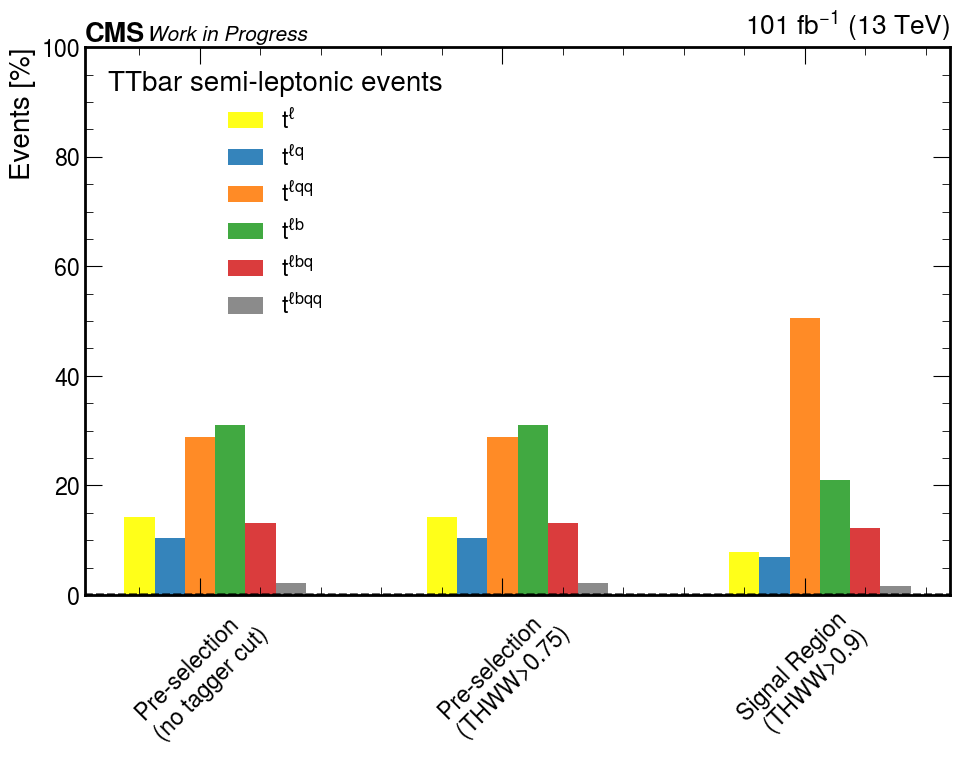

In [51]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

color_by_sample = {
    0: "yellow", 
    1: "tab:blue",
    2: "tab:orange",
    3: "tab:green",
    4: "tab:red",
    5: "tab:grey",
}

regions = {
    "Pre-selection \n (no tagger cut)": 0,
    "Pre-selection \n (THWW>0.75)": 0.75,
    "Signal Region \n (THWW>0.9)": 0.9,
}

df_combined = []
for year in years:
    for ch in channels:
        print(year, ch)
        df_combined.append(events_dict[year][ch]["TTbar"])

df_combined = pd.concat(df_combined)
df = df_combined

        
is_top_l = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]==0)

is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)
is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

is_top_lb = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]>=1)
is_top_lbq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]>=1)
is_top_lbqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]>=1)


samples = range(6)
bar_width = 0.1

fig, ax = plt.subplots(figsize=(10, 8))

for iregion, (region, cut) in enumerate(regions.items()):

    for i, (key, var) in enumerate(
        {
            r"$t^{\ell}$": is_top_l,
            r"$t^{{\ell}q}$": is_top_lq,
            r"$t^{{\ell}qq}$": is_top_lqq,
            r"$t^{{\ell}b}$": is_top_lb,
            r"$t^{{\ell}bq}$": is_top_lbq,
            r"$t^{{\ell}bqq}$": is_top_lbqq,
        }.items()
    ):

        X = 100 * (var & (df["THWW"]>cut)).sum() / sum(df["THWW"]>cut)
        bars = ax.bar(
            iregion + i * bar_width, 
            X, 
            bar_width, 
            color=color_by_sample[i],
            label=key,
            alpha=0.9,
        )
        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:len(samples)], ax.get_legend_handles_labels()[1][:len(samples)]
ax.legend(handles, labels, loc='upper left', title="TTbar semi-leptonic events")

ax.set_ylabel("Events [%]")
ax.set_ylim(0,100)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/LP_mquarks_TTbar.pdf")    

In [35]:
for key in df:
    if "isT" in key:
        print(key)

fj_isTop
fj_isTop_matched
fj_isTop_W_lep_b
fj_isTop_W_lep
fj_isTop_W_ele_b
fj_isTop_W_ele
fj_isTop_W_mu_b
fj_isTop_W_mu
fj_isTop_W_tau_b
fj_isTop_W_tau


## Retrieve the pfcands, genquark, and ak8 jet info

In [89]:
for year in years:
    for ch in channels:
        print(year, ch)
        df = events_dict[year][ch]["TTbar"]

        is_top_l = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]==0)

        is_top_lb = (df["fj_Top_nquarksnob"]==0) & (df["fj_Top_nbquarks"]>=1)
        is_top_lbq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]>=1)
        is_top_lbqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]>=1)

        is_top_lq = (df["fj_Top_nquarksnob"]==1) & (df["fj_Top_nbquarks"]==0)
        is_top_lqq = (df["fj_Top_nquarksnob"]==2) & (df["fj_Top_nbquarks"]==0)

        msk = is_top_lqq | is_top_lq
        df = df[msk]
        
        # (1) PFcands
        pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
        pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
        pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
        Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

        pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

        # (2) ak8 jet, and the THWW score
        ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_mass"].values], axis=-1)

        # (3) genQuarks
        etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
        phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

        gen_parts_eta_phi = np.stack([etas,phis], axis=-1)

        ############## RUN LPR
        #use small number of events for the example, but generally advisable to use larger sample
        max_evts = 100000000_000

        import sys, os
        sys.path.insert(0, '')
        sys.path.append("LundReweighting")
        from LundReweighting.utils.Utils import *

        """ An example how to use the Lund Plane reweighting  code. 
        Computes reweighting factors for an example signal. 
        Uses them to compute the efficiency and uncertainty of a given substructure cut"""

        ######################## Setup 

        #Input file 
        fname = "LundReweighting/data/example_signal.h5"
        f_ratio_name = f'LundReweighting/data/ratio_{year}.root'

        f_sig = h5py.File(fname, "r")
        f_ratio = ROOT.TFile.Open(f_ratio_name)

        #Class to help read input dataset 
        d = Dataset(f_sig, dtype = 1)
        d.compute_obs()

        #Main class for reweighting utilities
        LP_rw = LundReweighter(f_ratio = f_ratio)

        ################### Compute reweighting factors

        #PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
        pf_cands = pf_cands[:max_evts]
        print("Running on %i events" % len(pf_cands))

        #Generator level quarks from hard process 
        gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

        #4 vector of AK8 jets we are calibrating
        ak8_jets = ak8_jets[:max_evts]

        #Nominal event weights of the MC, (assume every event is weight '1' for this example)
        nom_weights = np.ones(len(pf_cands))

        #Compute reweighting factors and all systematic variations
        LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)

        #multiply Lund plane weights with nominal event weights
        for key in LP_weights.keys():
            if('nom' in key or 'up' in key or 'down' in key):
                if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= nom_weights


        #Fraction of prongs that are not well matched to subjets (want this to be low)
        print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
        #Fraction of prongs that are still not well matched after reclustering with varied number of prongs
        print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))

        events_dict[year][ch]["TTbar"][f"LP_weight_nom"] = 1
        events_dict[year][ch]["TTbar"][f"LP_weight_nom"][msk] = LP_weights["nom"]

        sys_keys = ['sys', 'prongs', 'unclust', 'distortion']
        
        for sys_key in sys_keys:
            for variation in ["up", "down"]:
                key = sys_key + "_" + variation

                events_dict[year][ch]["TTbar"][f"LP_weight_{key}"] = 1
                events_dict[year][ch]["TTbar"][f"LP_weight_{key}"][msk] = LP_weights[key]
        events_dict[year][ch]["TTbar"].to_parquet(f"LP_TTbar_{year}_{ch}.parquet")
#         break
#     break
        print("------------------------------")

2017 ele
Running on 1661 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.28
Reclustered bad match frac 0.08
------------------------------
2017 mu


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  events_dict[year][ch]["TTbar"][f"LP_weight_nom"][msk] = LP_weights["nom"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvk

Running on 1891 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.24
Reclustered bad match frac 0.09


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["TTbar"][f"LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

------------------------------
2018 ele
Running on 1659 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.26
Reclustered bad match frac 0.07
------------------------------
2018 mu


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["TTbar"][f"LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

Running on 1958 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.24
Reclustered bad match frac 0.09
------------------------------


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["TTbar"][f"LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_49112/2150141794.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

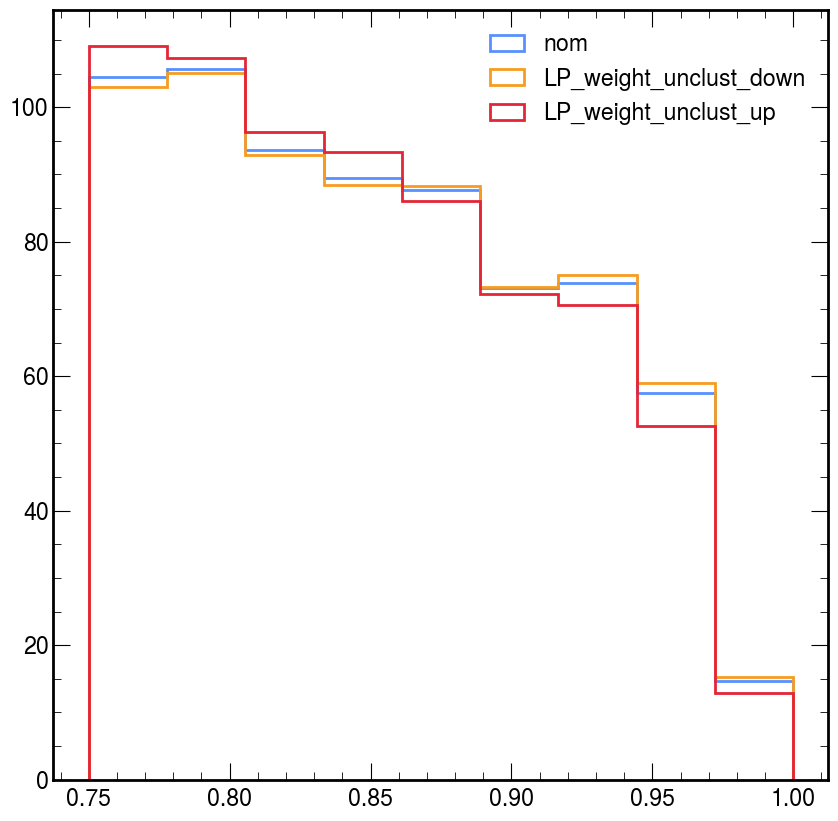

In [90]:
df = events_dict[year][ch]["TTbar"]

sys = "unclust"

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df["LP_weight"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
    lw=2,
#     density=True,
    label="nom",
)

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df[f"LP_weight_{sys}_down"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
#     density=True,
    lw=2,
    label=f"LP_weight_{sys}_down",
)

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df[f"LP_weight_{sys}_up"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
#     density=True,
    lw=2,
    label=f"LP_weight_{sys}_up",
)

plt.legend();

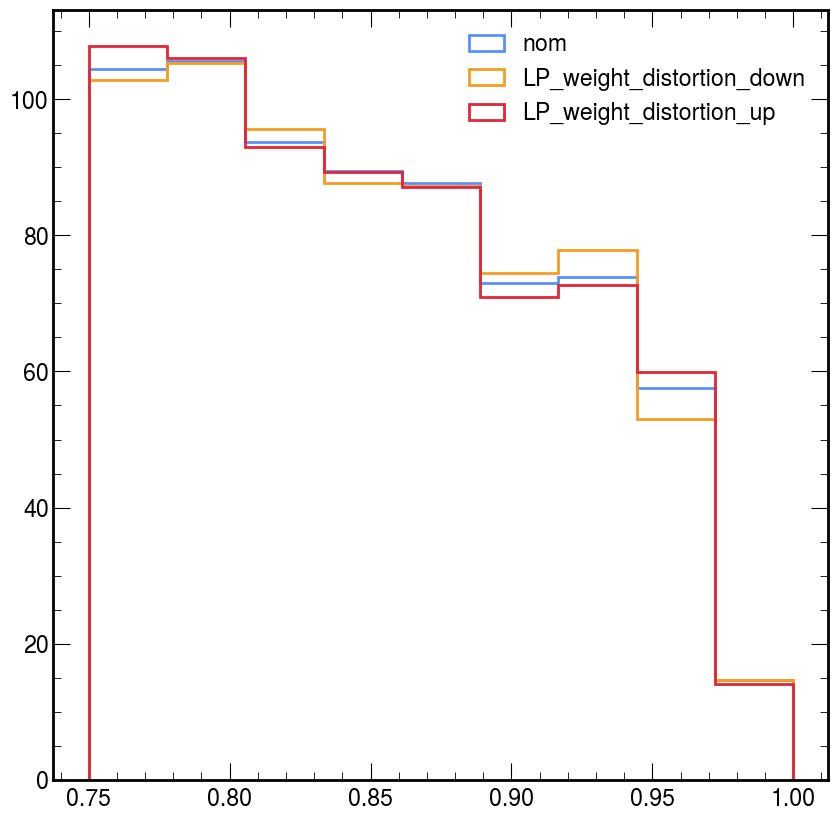

In [91]:
df = events_dict[year][ch]["TTbar"]

sys = "distortion"

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df["LP_weight"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
    lw=2,
#     density=True,
    label="nom",
)

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df[f"LP_weight_{sys}_down"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
#     density=True,
    lw=2,
    label=f"LP_weight_{sys}_down",
)

plt.hist(
    df["THWW"],
    weights=df["nominal"] * df[f"LP_weight_{sys}_up"],
    bins=np.linspace(0.75,1,10),
    histtype="step",
#     density=True,
    lw=2,
    label=f"LP_weight_{sys}_up",
)

plt.legend();

In [31]:
score_thresh = 0.75

score = df["THWW"].values[:max_evts]
score_cut = score < score_thresh

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))

#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]


#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.3f +/- %.3f (stat) +/- %.3f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.3f/%.3f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2

tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5

#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.3f, Calibrated %.3f +%.3f/-%.3f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

Nominal efficiency 0.875, Corrected efficiency 0.876, SF (corrected / nom) 1.001
Stat variation toys eff. avg 0.875, std dev 0.002
Pt variation toys eff. avg 0.876, std dev 0.000
Calibrated efficiency  is 0.876 +/- 0.003 (stat) +/- 0.000 (pt) 0.001/-0.003 (sys) 0.000/0.000 (bquark) -0.001/0.000 (prongs) 0.021/-0.009 (unclust) -0.001/0.009 (distortion)
 Original 0.875, Calibrated 0.876 +0.023/-0.010 



In [ ]:
# Nominal efficiency: eff in MC
# Calibrated efficiency: eff in data
# We reweight the efficiency in MC to look like the data
# Add more decimal points to see the unc.
# SF is very close to 1! follow up with Oz
# check at different cut

(array([2.20e+01, 1.33e+02, 4.47e+02, 8.54e+02, 2.22e+03, 5.24e+02,
        3.06e+02, 1.78e+02, 9.80e+01, 8.20e+01, 4.70e+01, 2.40e+01,
        2.00e+01, 1.30e+01, 7.00e+00, 6.00e+00, 4.00e+00, 2.00e+00,
        4.00e+00]),
 array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ]),
 <BarContainer object of 19 artists>)

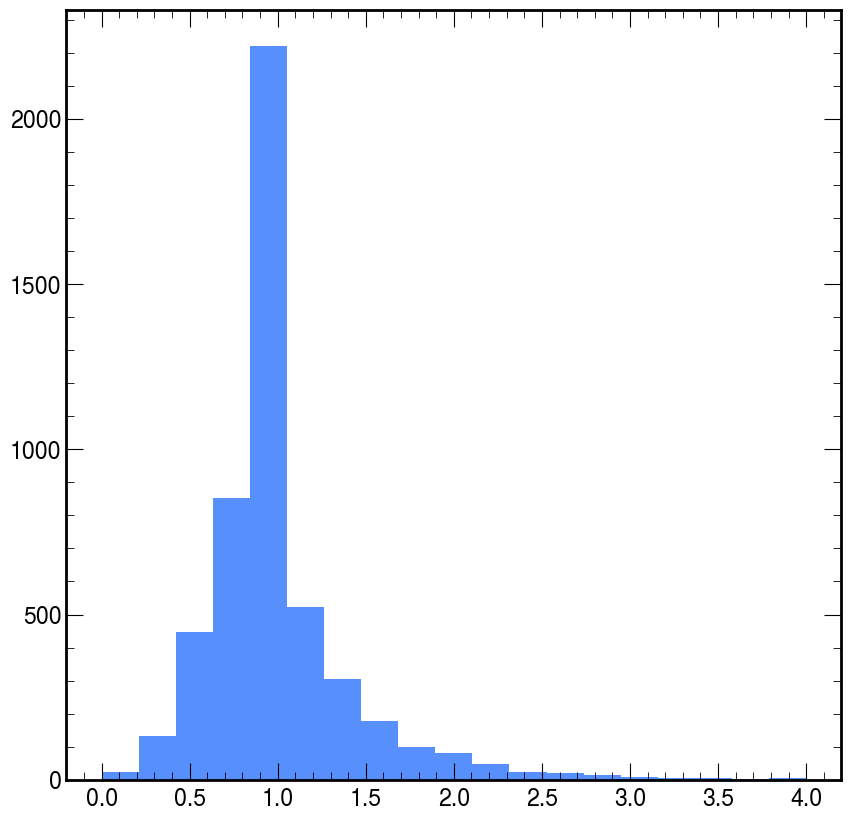

In [81]:
plt.hist(
    LP_weights["nom"],
    bins=np.linspace(0,4,20),
)

Text(1, 0, '$\\Delta$R(gen quark,subjet)')

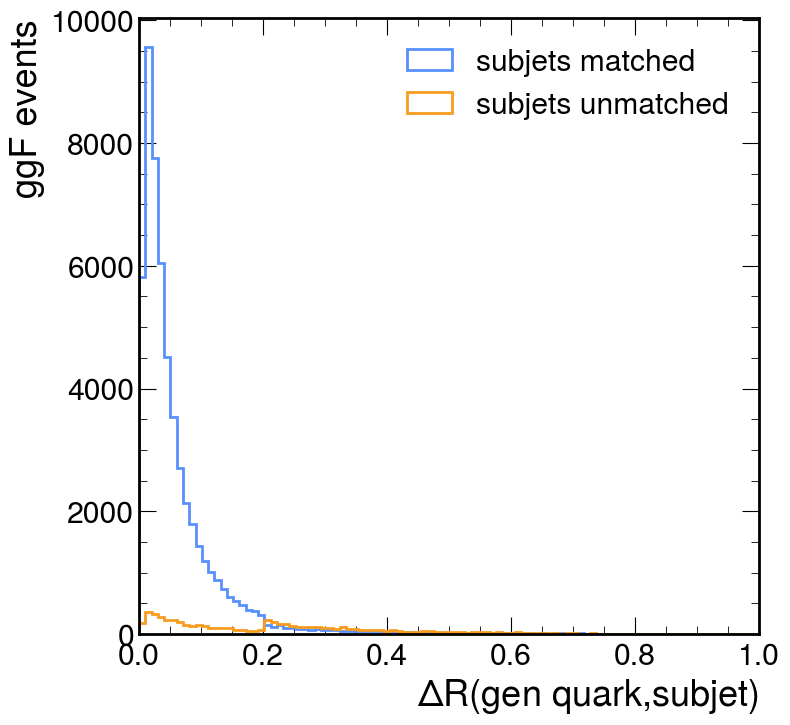

In [338]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(dRs[sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets matched")
ax.hist(dRs[~sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets unmatched")

ax.set_xlim(0,1)
ax.set_ylabel("TTbar events")
ax.legend()
ax.set_xlabel(r"$\Delta$R(gen quark,subjet)")

In [208]:
LP_weights["nom"].shape

(37359,)

In [209]:
LP_weights["nom"]

array([0.73024492, 1.16708584, 0.74874257, ..., 0.87880555, 1.11122473,
       0.64491165])

In [174]:
pd.DataFrame(LP_weights["nom"], columns=["LP_weight"]).to_parquet(f"LP_{ch}_{year}.parquet")

In [211]:
if max_evts == -1:
    score = df["THWW"].values
else:
    score = df["THWW"].values[:max_evts]
score_cut = score > 0.905

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]

#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.2f +/- %.2f (stat) +/- %.2f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.2f/%.2f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2



tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5
print()
#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.2f, Calibrated %.2f +%.2f/-%.2f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

Nominal efficiency 0.255, Corrected efficiency 0.242, SF (corrected / nom) 0.951
Stat variation toys eff. avg 0.242, std dev 0.005
Pt variation toys eff. avg 0.242, std dev 0.000

Calibrated efficiency  is 0.24 +/- 0.01 (stat) +/- 0.00 (pt) 0.00/0.00 (sys) 0.00/0.00 (bquark) 0.00/-0.01 (prongs) -0.06/0.02 (unclust) 0.00/-0.01 (distortion)
 Original 0.26, Calibrated 0.24 +0.02/-0.06 

